# Setup e Carregamento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
RANDOM_STATE = 42
N_FOLDS = 5

# Carregar dados processados
train = pd.read_csv('../data/processed/train_processed.csv')
test = pd.read_csv('../data/processed/test_processed.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Separar features e target
y = train['y']
X = train.drop(['y', 'id'], axis=1, errors='ignore')
X_test = test.drop(['id'], axis=1, errors='ignore')

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

# Verificar desbalanceamento
print(f"\nDistribuição do target:")
print(y.value_counts())
print(y.value_counts(normalize=True))

# Calcular scale_pos_weight para modelos tree-based
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print(f"\nScale pos weight: {scale_pos_weight:.2f}")

Train shape: (750000, 69)
Test shape: (250000, 68)

X shape: (750000, 67)
y shape: (750000,)
X_test shape: (250000, 67)

Distribuição do target:
y
0    659512
1     90488
Name: count, dtype: int64
y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

Scale pos weight: 7.29


# Analises de modelos

## Configuração da Validação Cruzada

In [2]:
# Stratified K-Fold para manter proporção das classes
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

def evaluate_model_cv(model, X, y, cv=skf):
    """
    Avalia modelo usando cross-validation
    Retorna: média e desvio padrão do AUC-ROC
    """
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Treinar
        model.fit(X_train_fold, y_train_fold)
        
        # Prever probabilidades
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # Calcular AUC
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(auc)
        
        print(f"Fold {fold}: AUC = {auc:.5f}")
    
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    
    print(f"\n{'='*50}")
    print(f"Mean AUC: {mean_auc:.5f} (+/- {std_auc:.5f})")
    print(f"{'='*50}\n")
    
    return mean_auc, std_auc, scores

print("✅ Validação cruzada configurada")


✅ Validação cruzada configurada


## Baseline - Logistic Regression

In [3]:
print("\n" + "="*70)
print("MODELO BASELINE: LOGISTIC REGRESSION")
print("="*70 + "\n")

# Modelo com class_weight para lidar com desbalanceamento
lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

# Avaliar com CV
lr_mean_auc, lr_std_auc, lr_scores = evaluate_model_cv(lr_model, X, y)

# Salvar resultado
baseline_results = {
    'model': 'Logistic Regression',
    'mean_auc': lr_mean_auc,
    'std_auc': lr_std_auc,
    'scores': lr_scores
}



MODELO BASELINE: LOGISTIC REGRESSION

Fold 1: AUC = 0.93547
Fold 2: AUC = 0.93557
Fold 3: AUC = 0.93407
Fold 4: AUC = 0.93658
Fold 5: AUC = 0.93603

Mean AUC: 0.93554 (+/- 0.00084)



## LightGBM - Modelo Principal

In [4]:
print("\n" + "="*70)
print("MODELO PRINCIPAL: LIGHTGBM")
print("="*70 + "\n")

# Parâmetros iniciais (baseline)
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

# Treinar com CV manual para ter controle
lgb_scores = []
lgb_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Criar datasets LightGBM
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    # Treinar
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Prever
    y_pred_proba = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    lgb_scores.append(auc)
    lgb_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}\n")

lgb_mean_auc = np.mean(lgb_scores)
lgb_std_auc = np.std(lgb_scores)

print(f"\n{'='*50}")
print(f"LightGBM Mean AUC: {lgb_mean_auc:.5f} (+/- {lgb_std_auc:.5f})")
print(f"{'='*50}\n")

# Salvar resultado
lgb_results = {
    'model': 'LightGBM',
    'mean_auc': lgb_mean_auc,
    'std_auc': lgb_std_auc,
    'scores': lgb_scores,
    'models': lgb_models
}



MODELO PRINCIPAL: LIGHTGBM

Training Fold 1/5
[100]	train's auc: 0.961649	valid's auc: 0.961695
[200]	train's auc: 0.965942	valid's auc: 0.965385
[300]	train's auc: 0.967703	valid's auc: 0.966392
[400]	train's auc: 0.968925	valid's auc: 0.966992
[500]	train's auc: 0.96996	valid's auc: 0.967429
[600]	train's auc: 0.970824	valid's auc: 0.967663
[700]	train's auc: 0.971623	valid's auc: 0.967878
[800]	train's auc: 0.97233	valid's auc: 0.968028
[900]	train's auc: 0.973107	valid's auc: 0.96824
[1000]	train's auc: 0.973794	valid's auc: 0.968348
Fold 1 AUC: 0.96835

Training Fold 2/5
[100]	train's auc: 0.961997	valid's auc: 0.960551
[200]	train's auc: 0.966303	valid's auc: 0.964301
[300]	train's auc: 0.968022	valid's auc: 0.965334
[400]	train's auc: 0.969136	valid's auc: 0.965768
[500]	train's auc: 0.970219	valid's auc: 0.966284
[600]	train's auc: 0.971106	valid's auc: 0.966563
[700]	train's auc: 0.971949	valid's auc: 0.966827
[800]	train's auc: 0.972692	valid's auc: 0.967027
[900]	train's au

## Feature Importance

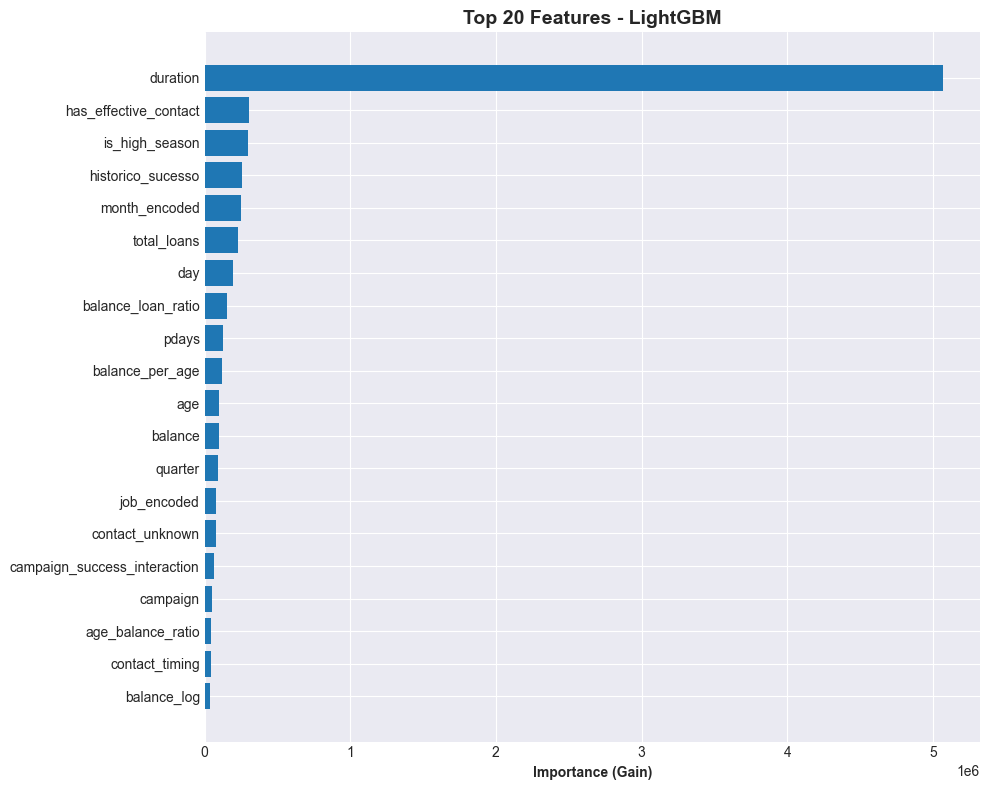


Top 20 Features Mais Importantes:
                         feature    importance
3                       duration  5.069777e+06
12         has_effective_contact  3.038172e+05
21                is_high_season  2.967837e+05
8              historico_sucesso  2.589286e+05
58                 month_encoded  2.495212e+05
41                   total_loans  2.282033e+05
2                            day  1.959485e+05
56            balance_loan_ratio  1.562663e+05
5                          pdays  1.257094e+05
39               balance_per_age  1.215380e+05
0                            age  1.021588e+05
1                        balance  9.925272e+04
23                       quarter  8.941369e+04
59                   job_encoded  8.137155e+04
65               contact_unknown  7.853623e+04
53  campaign_success_interaction  6.181433e+04
4                       campaign  5.335594e+04
52             age_balance_ratio  4.635290e+04
55                contact_timing  4.077547e+04
40                   bala

In [5]:
# Calcular importância média across folds
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

importances = []
for model in lgb_models:
    importances.append(model.feature_importance(importance_type='gain'))

feature_importance['importance'] = np.mean(importances, axis=0)
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizar top 20
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'].head(20)[::-1], 
         feature_importance['importance'].head(20)[::-1])
plt.xlabel('Importance (Gain)', fontweight='bold')
plt.title('Top 20 Features - LightGBM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 20 Features Mais Importantes:")
print(feature_importance.head(20))

# Salvar importâncias
feature_importance.to_csv('../data/processed/feature_importance.csv', index=False)


## XGBoost

In [6]:
print("\n" + "="*70)
print("MODELO: XGBOOST")
print("="*70 + "\n")

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}

xgb_scores = []
xgb_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Criar DMatrix
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
    
    # Treinar
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # Prever
    y_pred_proba = model.predict(dval, iteration_range=(0, model.best_iteration))
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    xgb_scores.append(auc)
    xgb_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}\n")

xgb_mean_auc = np.mean(xgb_scores)
xgb_std_auc = np.std(xgb_scores)

print(f"\n{'='*50}")
print(f"XGBoost Mean AUC: {xgb_mean_auc:.5f} (+/- {xgb_std_auc:.5f})")
print(f"{'='*50}\n")

xgb_results = {
    'model': 'XGBoost',
    'mean_auc': xgb_mean_auc,
    'std_auc': xgb_std_auc,
    'scores': xgb_scores,
    'models': xgb_models
}



MODELO: XGBOOST

Training Fold 1/5
[0]	train-auc:0.94272	valid-auc:0.94247
[100]	train-auc:0.96068	valid-auc:0.96023
[200]	train-auc:0.96557	valid-auc:0.96421
[300]	train-auc:0.96798	valid-auc:0.96572
[400]	train-auc:0.96956	valid-auc:0.96645
[500]	train-auc:0.97075	valid-auc:0.96687
[600]	train-auc:0.97183	valid-auc:0.96723
[700]	train-auc:0.97274	valid-auc:0.96745
[800]	train-auc:0.97361	valid-auc:0.96763
[900]	train-auc:0.97445	valid-auc:0.96781
[999]	train-auc:0.97518	valid-auc:0.96792
Fold 1 AUC: 0.96792

Training Fold 2/5
[0]	train-auc:0.94194	valid-auc:0.94122
[100]	train-auc:0.96087	valid-auc:0.95890
[200]	train-auc:0.96579	valid-auc:0.96297
[300]	train-auc:0.96825	valid-auc:0.96457
[400]	train-auc:0.96980	valid-auc:0.96532
[500]	train-auc:0.97108	valid-auc:0.96582
[600]	train-auc:0.97210	valid-auc:0.96610
[700]	train-auc:0.97304	valid-auc:0.96634
[800]	train-auc:0.97392	valid-auc:0.96652
[900]	train-auc:0.97470	valid-auc:0.96663
[999]	train-auc:0.97543	valid-auc:0.96672
Fold 

## CatBoost

In [7]:
print("\n" + "="*70)
print("MODELO: CATBOOST")
print("="*70 + "\n")

cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'scale_pos_weight': scale_pos_weight
}

cat_scores = []
cat_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nTraining Fold {fold}/{N_FOLDS}")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(**cat_params)
    
    # Treinar
    model.fit(
        X_train_fold, y_train_fold,
        eval_set=(X_val_fold, y_val_fold),
        verbose=False
    )
    
    # Prever
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    
    cat_scores.append(auc)
    cat_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}")

cat_mean_auc = np.mean(cat_scores)
cat_std_auc = np.std(cat_scores)

print(f"\n{'='*50}")
print(f"CatBoost Mean AUC: {cat_mean_auc:.5f} (+/- {cat_std_auc:.5f})")
print(f"{'='*50}\n")

cat_results = {
    'model': 'CatBoost',
    'mean_auc': cat_mean_auc,
    'std_auc': cat_std_auc,
    'scores': cat_scores,
    'models': cat_models
}



MODELO: CATBOOST


Training Fold 1/5
Fold 1 AUC: 0.96642

Training Fold 2/5
Fold 2 AUC: 0.96550

Training Fold 3/5
Fold 3 AUC: 0.96534

Training Fold 4/5
Fold 4 AUC: 0.96639

Training Fold 5/5
Fold 5 AUC: 0.96602

CatBoost Mean AUC: 0.96594 (+/- 0.00045)



## Comparação de Modelos


COMPARAÇÃO DE MODELOS
              model  mean_auc  std_auc
Logistic Regression  0.935543 0.000837
           LightGBM  0.967802 0.000450
            XGBoost  0.967298 0.000495
           CatBoost  0.965936 0.000449



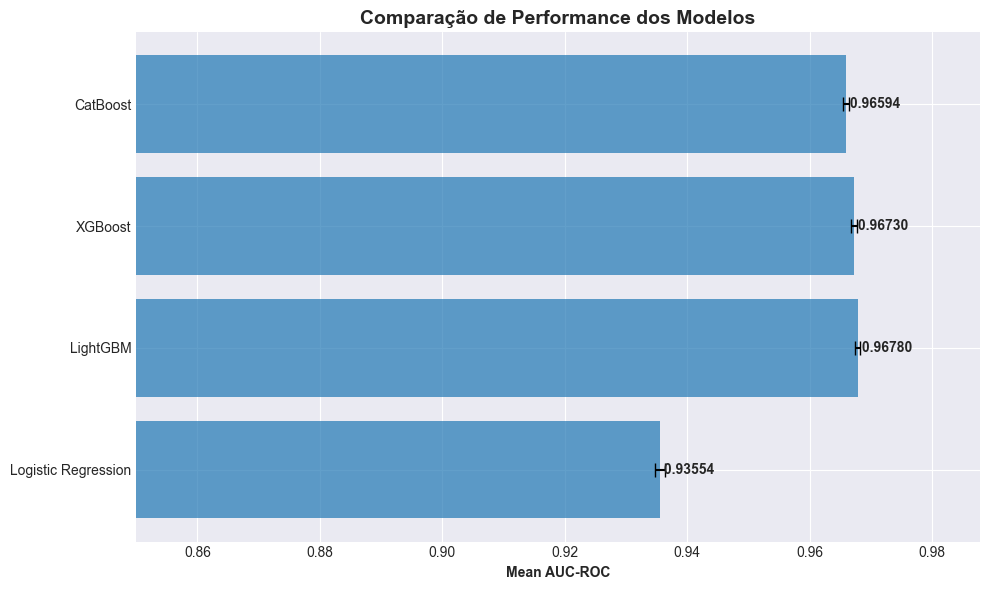

🏆 Melhor Modelo: LightGBM


In [8]:
results_comparison = pd.DataFrame([
    baseline_results,
    lgb_results,
    xgb_results,
    cat_results
])[['model', 'mean_auc', 'std_auc']]

print("\n" + "="*70)
print("COMPARAÇÃO DE MODELOS")
print("="*70)
print(results_comparison.to_string(index=False))
print("="*70 + "\n")

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(results_comparison['model'], results_comparison['mean_auc'], 
         xerr=results_comparison['std_auc'], capsize=5, alpha=0.7)
plt.xlabel('Mean AUC-ROC', fontweight='bold')
plt.title('Comparação de Performance dos Modelos', fontsize=14, fontweight='bold')
plt.xlim(0.85, results_comparison['mean_auc'].max() + 0.02)
for idx, row in results_comparison.iterrows():
    plt.text(row['mean_auc'], idx, f" {row['mean_auc']:.5f}", 
             va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Identificar melhor modelo
best_model_name = results_comparison.loc[results_comparison['mean_auc'].idxmax(), 'model']
print(f"🏆 Melhor Modelo: {best_model_name}")


# Gerar Predições para Submissão

In [9]:
def generate_predictions(models, X_test, model_name='ensemble'):
    """Gera predições usando média dos modelos (ensemble)"""
    
    predictions = []
    
    for model in models:
        if model_name == 'LightGBM':
            pred = model.predict(X_test, num_iteration=model.best_iteration)
        elif model_name == 'XGBoost':
            dtest = xgb.DMatrix(X_test)
            pred = model.predict(dtest, iteration_range=(0, model.best_iteration))
        else:  # CatBoost
            pred = model.predict_proba(X_test)[:, 1]
        
        predictions.append(pred)
    
    # Média das predições (ensemble dos folds)
    final_predictions = np.mean(predictions, axis=0)
    
    return final_predictions

# Gerar predições para cada modelo
print("\nGerando predições...")

lgb_predictions = generate_predictions(lgb_models, X_test, 'LightGBM')
xgb_predictions = generate_predictions(xgb_models, X_test, 'XGBoost')
cat_predictions = generate_predictions(cat_models, X_test, 'CatBoost')

# Ensemble final: média ponderada pelos scores de CV
total_score = lgb_mean_auc + xgb_mean_auc + cat_mean_auc
lgb_weight = lgb_mean_auc / total_score
xgb_weight = xgb_mean_auc / total_score
cat_weight = cat_mean_auc / total_score

ensemble_predictions = (lgb_weight * lgb_predictions + 
                        xgb_weight * xgb_predictions + 
                        cat_weight * cat_predictions)

print(f"\nPesos do ensemble:")
print(f"  LightGBM: {lgb_weight:.3f}")
print(f"  XGBoost: {xgb_weight:.3f}")
print(f"  CatBoost: {cat_weight:.3f}")

# Criar submission files
test_ids = test['id'].values if 'id' in test.columns else range(len(test))

submissions = {
    'lgb': lgb_predictions,
    'xgb': xgb_predictions,
    'cat': cat_predictions,
    'ensemble': ensemble_predictions
}

for name, preds in submissions.items():
    submission = pd.DataFrame({
        'id': test_ids,
        'y': preds
    })
    submission.to_csv(f'../submissions/submission_{name}.csv', index=False)
    print(f"✅ Arquivo salvo: submission_{name}.csv")

print("\n🎯 Submissões prontas! Recomendo testar o ensemble primeiro.")



Gerando predições...

Pesos do ensemble:
  LightGBM: 0.334
  XGBoost: 0.333
  CatBoost: 0.333
✅ Arquivo salvo: submission_lgb.csv
✅ Arquivo salvo: submission_xgb.csv
✅ Arquivo salvo: submission_cat.csv
✅ Arquivo salvo: submission_ensemble.csv

🎯 Submissões prontas! Recomendo testar o ensemble primeiro.


## Ensemble


COMPARAÇÃO DE PREDIÇÕES - Primeiros 10 Clientes
    id  LightGBM  XGBoost  CatBoost  Ensemble
750000  0.013838 0.009763  0.033572  0.019050
750001  0.562134 0.487280  0.557407  0.535601
750002  0.001077 0.000952  0.002998  0.001675
750003  0.000180 0.000200  0.000639  0.000340
750004  0.126214 0.123785  0.151849  0.133940
750005  0.006242 0.008558  0.009026  0.007941
750006  0.733191 0.685151  0.698635  0.705667
750007  0.803681 0.747933  0.839152  0.796903
750008  0.055466 0.044626  0.099470  0.066503
750009  0.810924 0.740999  0.755446  0.769137

Média das diferenças entre modelos:
  LightGBM vs XGBoost: 0.02684
  LightGBM vs CatBoost: 0.02248
  XGBoost vs CatBoost: 0.02989


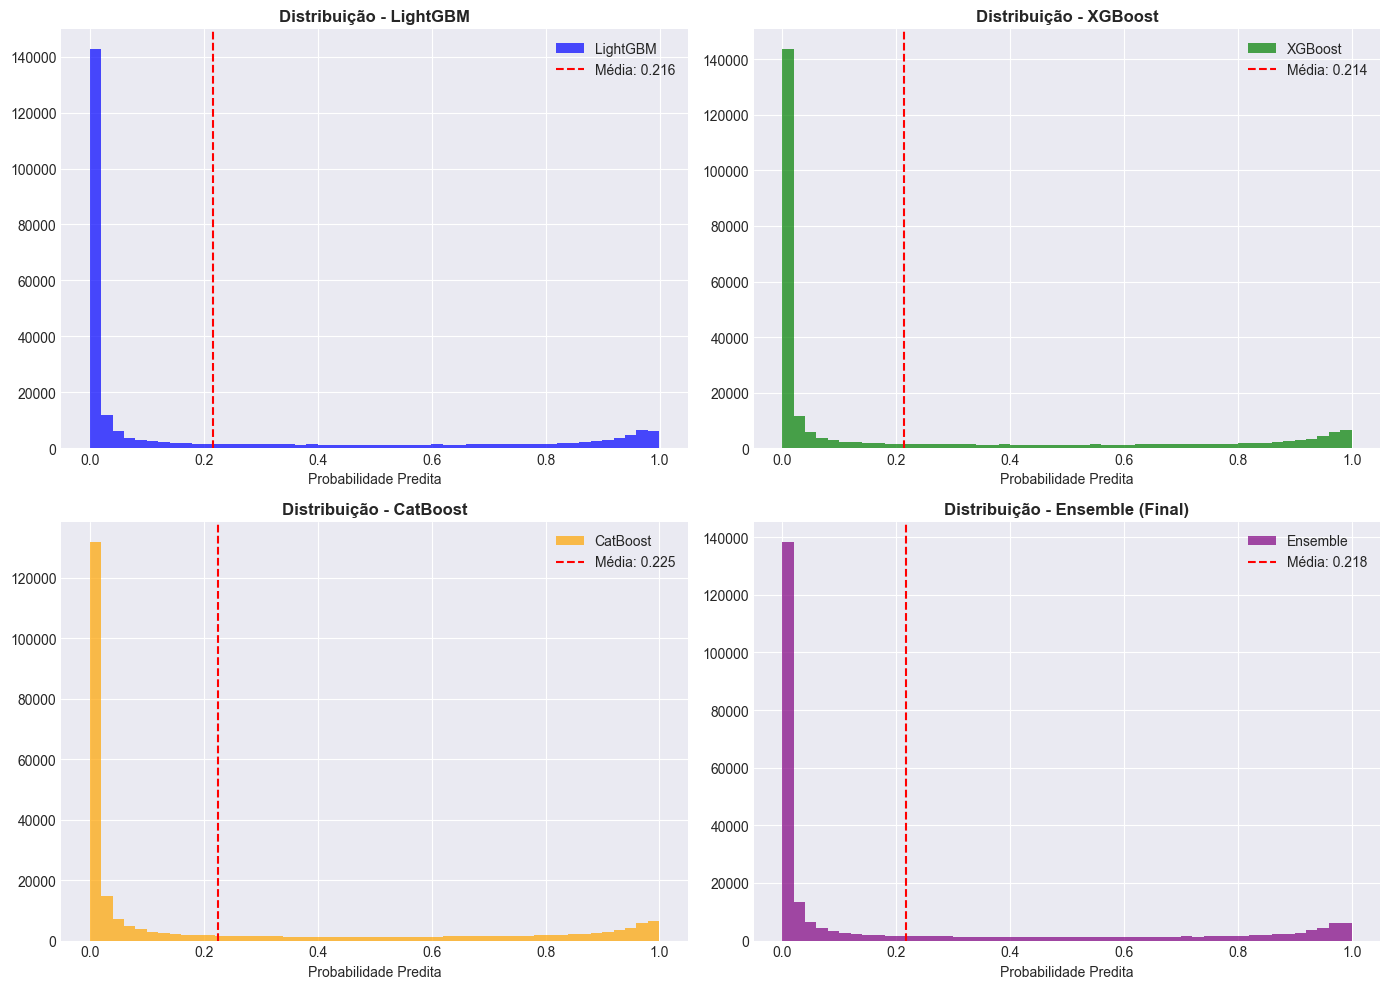


ESTATÍSTICAS DAS PREDIÇÕES

LightGBM:
  Média: 0.21558
  Min: 0.00001
  Max: 0.99907
  Std: 0.33809

XGBoost:
  Média: 0.21370
  Min: 0.00001
  Max: 0.99955
  Std: 0.33714

CatBoost:
  Média: 0.22453
  Min: 0.00005
  Max: 0.99928
  Std: 0.33816

🎯 ENSEMBLE (FINAL):
  Média: 0.21793
  Min: 0.00005
  Max: 0.99920
  Std: 0.33718

CORRELAÇÃO ENTRE MODELOS
          LightGBM   XGBoost  CatBoost
LightGBM  1.000000  0.996247  0.994575
XGBoost   0.996247  1.000000  0.992865
CatBoost  0.994575  0.992865  1.000000

💡 Correlação alta (>0.95) = modelos muito similares
💡 Correlação moderada (0.85-0.95) = ideal para ensemble!


In [10]:
# Comparar predições dos 3 modelos (primeiros 10 clientes)
comparison_df = pd.DataFrame({
    'id': test_ids[:10],
    'LightGBM': lgb_predictions[:10],
    'XGBoost': xgb_predictions[:10],
    'CatBoost': cat_predictions[:10],
    'Ensemble': ensemble_predictions[:10]
})

print("\n" + "="*70)
print("COMPARAÇÃO DE PREDIÇÕES - Primeiros 10 Clientes")
print("="*70)
print(comparison_df.to_string(index=False))

# Calcular diferenças
comparison_df['diff_lgb_xgb'] = abs(comparison_df['LightGBM'] - comparison_df['XGBoost'])
comparison_df['diff_lgb_cat'] = abs(comparison_df['LightGBM'] - comparison_df['CatBoost'])
comparison_df['diff_xgb_cat'] = abs(comparison_df['XGBoost'] - comparison_df['CatBoost'])

print(f"\nMédia das diferenças entre modelos:")
print(f"  LightGBM vs XGBoost: {comparison_df['diff_lgb_xgb'].mean():.5f}")
print(f"  LightGBM vs CatBoost: {comparison_df['diff_lgb_cat'].mean():.5f}")
print(f"  XGBoost vs CatBoost: {comparison_df['diff_xgb_cat'].mean():.5f}")

# Visualizar distribuição das predições
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(lgb_predictions, bins=50, alpha=0.7, label='LightGBM', color='blue')
axes[0, 0].set_title('Distribuição - LightGBM', fontweight='bold')
axes[0, 0].set_xlabel('Probabilidade Predita')
axes[0, 0].axvline(lgb_predictions.mean(), color='red', linestyle='--', 
                    label=f'Média: {lgb_predictions.mean():.3f}')
axes[0, 0].legend()

axes[0, 1].hist(xgb_predictions, bins=50, alpha=0.7, label='XGBoost', color='green')
axes[0, 1].set_title('Distribuição - XGBoost', fontweight='bold')
axes[0, 1].set_xlabel('Probabilidade Predita')
axes[0, 1].axvline(xgb_predictions.mean(), color='red', linestyle='--',
                    label=f'Média: {xgb_predictions.mean():.3f}')
axes[0, 1].legend()

axes[1, 0].hist(cat_predictions, bins=50, alpha=0.7, label='CatBoost', color='orange')
axes[1, 0].set_title('Distribuição - CatBoost', fontweight='bold')
axes[1, 0].set_xlabel('Probabilidade Predita')
axes[1, 0].axvline(cat_predictions.mean(), color='red', linestyle='--',
                    label=f'Média: {cat_predictions.mean():.3f}')
axes[1, 0].legend()

axes[1, 1].hist(ensemble_predictions, bins=50, alpha=0.7, label='Ensemble', color='purple')
axes[1, 1].set_title('Distribuição - Ensemble (Final)', fontweight='bold')
axes[1, 1].set_xlabel('Probabilidade Predita')
axes[1, 1].axvline(ensemble_predictions.mean(), color='red', linestyle='--',
                    label=f'Média: {ensemble_predictions.mean():.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Estatísticas das predições
print("\n" + "="*70)
print("ESTATÍSTICAS DAS PREDIÇÕES")
print("="*70)
print(f"\nLightGBM:")
print(f"  Média: {lgb_predictions.mean():.5f}")
print(f"  Min: {lgb_predictions.min():.5f}")
print(f"  Max: {lgb_predictions.max():.5f}")
print(f"  Std: {lgb_predictions.std():.5f}")

print(f"\nXGBoost:")
print(f"  Média: {xgb_predictions.mean():.5f}")
print(f"  Min: {xgb_predictions.min():.5f}")
print(f"  Max: {xgb_predictions.max():.5f}")
print(f"  Std: {xgb_predictions.std():.5f}")

print(f"\nCatBoost:")
print(f"  Média: {cat_predictions.mean():.5f}")
print(f"  Min: {cat_predictions.min():.5f}")
print(f"  Max: {cat_predictions.max():.5f}")
print(f"  Std: {cat_predictions.std():.5f}")

print(f"\n🎯 ENSEMBLE (FINAL):")
print(f"  Média: {ensemble_predictions.mean():.5f}")
print(f"  Min: {ensemble_predictions.min():.5f}")
print(f"  Max: {ensemble_predictions.max():.5f}")
print(f"  Std: {ensemble_predictions.std():.5f}")

# Correlação entre modelos
corr_matrix = pd.DataFrame({
    'LightGBM': lgb_predictions,
    'XGBoost': xgb_predictions,
    'CatBoost': cat_predictions
}).corr()

print("\n" + "="*70)
print("CORRELAÇÃO ENTRE MODELOS")
print("="*70)
print(corr_matrix)
print("\n💡 Correlação alta (>0.95) = modelos muito similares")
print("💡 Correlação moderada (0.85-0.95) = ideal para ensemble!")


# Outros testes

## Teste sem duration

In [11]:
print("\n" + "="*70)
print("TESTE: MODELOS SEM DURATION")
print("="*70 + "\n")

# Remover duration
X_no_duration = X.drop('duration', axis=1, errors='ignore')
X_test_no_duration = X_test.drop('duration', axis=1, errors='ignore')

print(f"Features sem duration: {X_no_duration.shape[1]}")

# Treinar LightGBM sem duration
lgb_scores_no_dur = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_no_duration, y), 1):
    X_train_fold = X_no_duration.iloc[train_idx]
    X_val_fold = X_no_duration.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred)
    lgb_scores_no_dur.append(auc)
    print(f"Fold {fold} AUC (sem duration): {auc:.5f}")

print(f"\nMean AUC sem duration: {np.mean(lgb_scores_no_dur):.5f}")
print(f"Comparação:")
print(f"  COM duration: {lgb_mean_auc:.5f}")
print(f"  SEM duration: {np.mean(lgb_scores_no_dur):.5f}")
print(f"  Diferença: {lgb_mean_auc - np.mean(lgb_scores_no_dur):.5f}")



TESTE: MODELOS SEM DURATION

Features sem duration: 66
Fold 1 AUC (sem duration): 0.85956
Fold 2 AUC (sem duration): 0.85474
Fold 3 AUC (sem duration): 0.85611
Fold 4 AUC (sem duration): 0.85623
Fold 5 AUC (sem duration): 0.85481

Mean AUC sem duration: 0.85629
Comparação:
  COM duration: 0.96780
  SEM duration: 0.85629
  Diferença: 0.11151


## Hyperparameter Tuning com Optuna

In [12]:
def objective(trial):
    """Função objetivo para Optuna"""
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'scale_pos_weight': scale_pos_weight,
        'random_state': RANDOM_STATE,
        'verbose': -1
    }
    
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
        
        model = lgb.train(
            params,
            train_data,
            num_boost_round=500,
            valid_sets=[val_data],
            callbacks=[lgb.early_stopping(30, verbose=False)]
        )
        
        y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        auc = roc_auc_score(y_val_fold, y_pred)
        cv_scores.append(auc)
    
    return np.mean(cv_scores)

# Rodar otimização
print("\n🔧 Iniciando Hyperparameter Tuning...")
print("Isso pode levar alguns minutos...\n")

study = optuna.create_study(direction='maximize', study_name='lgb_optimization')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "="*70)
print("MELHORES HIPERPARÂMETROS")
print("="*70)
print(f"\nMelhor AUC: {study.best_value:.5f}")
print(f"Melhoria sobre baseline: +{study.best_value - lgb_mean_auc:.5f}")
print("\nMelhores parâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


[I 2025-12-05 12:52:31,262] A new study created in memory with name: lgb_optimization



🔧 Iniciando Hyperparameter Tuning...
Isso pode levar alguns minutos...



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-05 12:53:48,761] Trial 0 finished with value: 0.9665893304026989 and parameters: {'num_leaves': 34, 'learning_rate': 0.057552443209321236, 'feature_fraction': 0.7511817245695072, 'bagging_fraction': 0.66854477847161, 'bagging_freq': 6, 'min_child_samples': 5, 'max_depth': 7}. Best is trial 0 with value: 0.9665893304026989.
[I 2025-12-05 12:55:31,800] Trial 1 finished with value: 0.9679292679000833 and parameters: {'num_leaves': 70, 'learning_rate': 0.08337296385915985, 'feature_fraction': 0.7904052446132924, 'bagging_fraction': 0.7500958031982801, 'bagging_freq': 5, 'min_child_samples': 45, 'max_depth': 10}. Best is trial 1 with value: 0.9679292679000833.
[I 2025-12-05 12:56:53,881] Trial 2 finished with value: 0.965960421216795 and parameters: {'num_leaves': 20, 'learning_rate': 0.04987416659570349, 'feature_fraction': 0.6727077440862634, 'bagging_fraction': 0.9866177786513713, 'bagging_freq': 7, 'min_child_samples': 27, 'max_depth': 12}. Best is trial 1 with value: 0.96792

## Feature Selection

In [13]:
# Carregar feature importance
feature_importance = pd.read_csv('../data/processed/feature_importance.csv')

# Testar com top 30 features
top_n = 30
top_features = feature_importance.head(top_n)['feature'].tolist()

print(f"\nTestando com top {top_n} features:")
print(top_features)

X_selected = X[top_features]
X_test_selected = X_test[top_features]

# Treinar com features selecionadas
lgb_scores_selected = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_selected, y), 1):
    X_train_fold = X_selected.iloc[train_idx]
    X_val_fold = X_selected.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred)
    lgb_scores_selected.append(auc)
    print(f"Fold {fold} AUC (top {top_n}): {auc:.5f}")

print(f"\nMean AUC (top {top_n}): {np.mean(lgb_scores_selected):.5f}")
print(f"Comparação com todas features: {lgb_mean_auc:.5f}")



Testando com top 30 features:
['duration', 'has_effective_contact', 'is_high_season', 'historico_sucesso', 'month_encoded', 'total_loans', 'day', 'balance_loan_ratio', 'pdays', 'balance_per_age', 'age', 'balance', 'quarter', 'job_encoded', 'contact_unknown', 'campaign_success_interaction', 'campaign', 'age_balance_ratio', 'contact_timing', 'balance_log', 'is_may', 'sem_dividas', 'total_contacts', 'education_encoded', 'contact_cellular', 'is_single', 'perfil_premium', 'has_housing', 'pdays_category', 'previous']
Fold 1 AUC (top 30): 0.96823
Fold 2 AUC (top 30): 0.96713
Fold 3 AUC (top 30): 0.96732
Fold 4 AUC (top 30): 0.96824
Fold 5 AUC (top 30): 0.96752

Mean AUC (top 30): 0.96769
Comparação com todas features: 0.96780


# Rodadas finais

## Hiperparâmetros otimizados

In [ ]:
print("\n" + "="*70)
print("TREINANDO MODELO FINAL COM HIPERPARÂMETROS OTIMIZADOS")
print("="*70 + "\n")

# Melhores parâmetros do Optuna
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 88,
    'learning_rate': 0.0679235909913875,
    'feature_fraction': 0.6008994544769531,
    'bagging_fraction': 0.9617438469454634,
    'bagging_freq': 1,
    'min_child_samples': 48,
    'max_depth': 12,
    'scale_pos_weight': scale_pos_weight,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

# Treinar com CV
tuned_models = []
tuned_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Training Fold {fold}/{N_FOLDS}")
    
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
    
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=2000,  # Mais iterações
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, verbose=False),
            lgb.log_evaluation(period=200)
        ]
    )
    
    y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_val_fold, y_pred)
    
    tuned_scores.append(auc)
    tuned_models.append(model)
    
    print(f"Fold {fold} AUC: {auc:.5f}")
    print(f"Best iteration: {model.best_iteration}\n")

tuned_mean_auc = np.mean(tuned_scores)
tuned_std_auc = np.std(tuned_scores)

print(f"\n{'='*70}")
print(f"TUNED MODEL - Mean AUC: {tuned_mean_auc:.5f} (+/- {tuned_std_auc:.5f})")
print(f"Baseline Model - Mean AUC: {lgb_mean_auc:.5f}")
print(f"Improvement: +{tuned_mean_auc - lgb_mean_auc:.5f}")
print(f"{'='*70}\n")

# Gerar predições
tuned_predictions = []
for model in tuned_models:
    pred = model.predict(X_test, num_iteration=model.best_iteration)
    tuned_predictions.append(pred)

tuned_final_pred = np.mean(tuned_predictions, axis=0)

# Salvar submissão
submission_tuned = pd.DataFrame({
    'id': test['id'].values if 'id' in test.columns else range(len(test)),
    'y': tuned_final_pred
})
submission_tuned.to_csv('../submissions/submission_lgb_tuned.csv', index=False)
print("✅ Submissão salva: submission_lgb_tuned.csv")


## Ensemble Otimizado (LightGBM Tuned + XGBoost + CatBoost)

In [ ]:
print("\n" + "="*70)
print("CRIANDO ENSEMBLE FINAL")
print("="*70 + "\n")

# Pesos baseados em performance
models_performance = {
    'tuned_lgb': tuned_mean_auc,
    'xgb': xgb_mean_auc,
    'cat': cat_mean_auc
}

print("Performance dos modelos:")
for name, score in models_performance.items():
    print(f"  {name}: {score:.5f}")

# Calcular pesos
total_score = sum(models_performance.values())
weights = {k: v/total_score for k, v in models_performance.items()}

print("\nPesos do ensemble:")
for name, weight in weights.items():
    print(f"  {name}: {weight:.4f}")

# Ensemble ponderado
ensemble_final = (
    weights['tuned_lgb'] * tuned_final_pred + 
    weights['xgb'] * xgb_predictions + 
    weights['cat'] * cat_predictions
)

# Salvar
submission_ensemble = pd.DataFrame({
    'id': test['id'].values if 'id' in test.columns else range(len(test)),
    'y': ensemble_final
})
submission_ensemble.to_csv('../submissions/submission_ensemble_optimized.csv', index=False)
print("\n✅ Ensemble otimizado salvo: submission_ensemble_optimized.csv")

# Comparação das distribuições
print("\n" + "="*70)
print("COMPARAÇÃO DAS PREDIÇÕES")
print("="*70)
print(f"\nLightGBM Tuned:")
print(f"  Média: {tuned_final_pred.mean():.5f}")
print(f"  Min: {tuned_final_pred.min():.5f}")
print(f"  Max: {tuned_final_pred.max():.5f}")

print(f"\nEnsemble Otimizado:")
print(f"  Média: {ensemble_final.mean():.5f}")
print(f"  Min: {ensemble_final.min():.5f}")
print(f"  Max: {ensemble_final.max():.5f}")
